### Import the required Libraries

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
#supress warnings
import warnings
warnings.filterwarnings("ignore")

#preprocessing Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#Calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Train test split
from sklearn.model_selection import train_test_split,GridSearchCV

#variance threshold
from sklearn.feature_selection import VarianceThreshold

#Import classification models
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

#Import Trees
from sklearn.tree import DecisionTreeClassifier

#Import Metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_auc_score,roc_curve,classification_report,auc,precision_recall_curve,accuracy_score,f1_score,fbeta_score, precision_score, recall_score

#Import ensemble techniques
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

### Import the data

In [2]:
data_df=pd.read_excel("Consumer creditworthiness train data.xlsx")

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            521 non-null    int64  
 1   Gender             511 non-null    object 
 2   Married            518 non-null    object 
 3   Dependents         508 non-null    object 
 4   Education          521 non-null    object 
 5   Self_Employed      494 non-null    object 
 6   ApplicantIncome    521 non-null    int64  
 7   CoapplicantIncome  521 non-null    float64
 8   LoanAmount         521 non-null    int64  
 9   Loan_Amount_Term   507 non-null    float64
 10  Credit_History     478 non-null    float64
 11  Property_Area      521 non-null    object 
 12  Loan_Status        521 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 53.0+ KB


#### Inferences:

1. There are 3columns with Integer datatype
2. There are 3columns with Float datatype
3. There are 7columns with Object datatype
4. There are missing values in some of the columns
5. There are 521 records with 13 columns

In [4]:
def custom_summary_func1(data_df):
    """
    This is a custom sumamry function
    Input: Accepts a dataframe
    Analyses each and evry columns and displays the 5 point summary, skewness , jurtusis and checks for outliers
    output: Summary Dataframe
    """
    summary=[]#list of dicts 
    for col in data_df.columns:

        if(data_df[col].dtypes!='object'):
            # calculates the summary for numeric data 
            # create a dictionary which contains all the attributes for a feature
            q1=data_df[col].quantile(0.25)
            q3=data_df[col].quantile(0.75)
            iqr=q3-q1
            result_dict=OrderedDict({
            'Feature_Name':col,
            'Count':data_df[col].count(),
            'lower_whisker' : q1-1.5*iqr,
            'min':data_df[col].min(),
            'Q1':q1,
            'Q2':data_df[col].quantile(0.50),
            'Q3':q3,
            'upper_whisker' : q3+1.5*iqr,
            'max':data_df[col].max(),
            'mean':data_df[col].mean(),
            'variance':np.round(data_df[col].var(),2),
            'std_dev':data_df[col].std(),
            'skewness': data_df[col].skew(),
            'kurtosis': data_df[col].kurt()})

            summary.append(result_dict)
    final_summary_df=pd.DataFrame(summary)
    #skewness
    #After the initial summary dict is created look at the skewness and kutusis values and add a label
    #how it is skewed and what type of kurtusis is present.
    # also check for outliers and add a comment
    #traverse each column and check the skewness value. Basesd on the value add the skewness label.
    skewness_label=[]
    for i in final_summary_df['skewness']:
        if i<= -1:
            skewness_label.append('Highly negatively skewed')
        elif -1 <=i <= -0.5:
            skewness_label.append('Moderately Negatively skewed')
        elif -0.5 <= i <= 0:
            skewness_label.append('Fairly negatively skewed')
        elif 0 <= i <= 0.5:
            skewness_label.append('Fairly positively skewed')
        elif 0.5 <= i <= 1:
            skewness_label.append('Moderately positively skewed')
        elif i >= 1:
            skewness_label.append('Highly positively skewed')
    final_summary_df['skewness_comment']=skewness_label

    #kurtosis
    #traverse each column and check the kurtusis value. Basesd on the value add the kurtusis label.
    kurtosis_label=[]
    for i in final_summary_df['kurtosis']:
        if i >=1 :
            kurtosis_label.append('Leptokurtic')
        elif i <= -1:
            kurtosis_label.append('Platykurtic')
        else:
            kurtosis_label.append('Mesokurtic')
    final_summary_df['kurtosis_comment']=kurtosis_label

    #Outliers
    #traverse each column and check the number of values where are lying beyond the whiskers. 
    #If the count >1 then the col has outliers
    outliers_label=[]
    for col in data_df.columns:
        if(data_df[col].dtypes!='object'):
            q1=data_df[col].quantile(0.25)
            q2=data_df[col].quantile(0.50)
            q3=data_df[col].quantile(0.75)
            iqr=q3-q1
            lower_whisker = q1-1.5*iqr
            upper_whisker = q3+1.5*iqr
            if len( data_df[ (data_df[col]<lower_whisker) | (data_df[col]>upper_whisker) ]) > 0:
                outliers_label.append('Has Outliers')
            else:
                outliers_label.append('No Outliers')

    final_summary_df['outlier_comment']= outliers_label
    return final_summary_df;

In [5]:
def custom_summary_func2(data_df,column_name):
    """
    This is a custom summary function
    Input: Accepts a dataframe and column name whose summary as to be displayed
    It displays the count of each category as well as the proportion of the values in the category 
    output: value_counts_df,column_name_vs_loanstatus_df
    """
    if(data_df[column_name].dtypes=='object'):
        val_count_series=data_df[column_name].value_counts()
        val_count_proportion_series=data_df[column_name].value_counts(normalize=True)
        val_count_df1 = val_count_series.to_frame().reset_index()
        val_count_df2 = val_count_proportion_series.to_frame().reset_index()
        val_count_df1.columns=[column_name,'Count']
        val_count_df2.columns=[column_name,'Proportion']
        val_count_df=pd.merge(val_count_df1,val_count_df2,on=column_name)
        
        col_vs_loanstatus_ser=(data_df[[column_name,'Loan_Status']].groupby(column_name).value_counts(normalize=True))
        col_vs_loanstatus_df=col_vs_loanstatus_ser.to_frame().reset_index()
        col_vs_loanstatus_df.columns=[column_name,'Loan_Status','Proportion']
        
        Loan_Status_yes=col_vs_loanstatus_df[col_vs_loanstatus_df['Loan_Status']=='Y'][[column_name,'Proportion']]
        Loan_Status_yes.columns=[column_name,'Proportion_Loan_Status_Y']
        
        
        Loan_Status_no=col_vs_loanstatus_df[col_vs_loanstatus_df['Loan_Status']=='N'][[column_name,'Proportion']]
        Loan_Status_no.columns=[column_name,'Proportion_Loan_Status_N']
        
        summary_df=val_count_df.merge(Loan_Status_yes,how='inner', on=column_name)
        summary_df=summary_df.merge(Loan_Status_no,how='inner',on=column_name)
       
    else:
        print('Please pass Object datatype columns')
    return summary_df

In [6]:
def find_missing_values(df): 
    """
    findout percentage of missing values in the dataframe
    input: Dataframe
    output: list with missing vlaues and dataframe which shows the cols and % of missing values in it.
    """
    #list of tuples (column_name, percent of missing values)
    missing_cols_list=[]
    for each in df.columns:
        missing_values=(df[each].isnull().sum()/df.shape[0])*100
        if(missing_values>0):
            missing_cols_list.append((each,(str(np.round(missing_values,3))+'%')))
            
    temp_dict = dict((x,y) for x, y in enumerate(missing_cols_list))
    missing_value_df=pd.DataFrame.from_dict(temp_dict)
    return missing_cols_list,missing_value_df

In [7]:
def treat_missing_values(df,cols_list_with_missing_values):
    """
    This function treats the missing values in a data frame.
    Input: dataframe-with missing values, 
           cols_list_with_missing_values- List of columns which have missing values
    Output: None- this function jus treats the columns with missing values
    """
    for index, tup in enumerate(cols_list_with_missing_values):
        if(df[tup[0]].dtype=='O'):
            df[tup[0]]=df[tup[0]].fillna(df[tup[0]].mode()[0])
        else:
            df[tup[0]]=df[tup[0]].fillna(df[tup[0]].median())

In [8]:
def visualise_features(df,col_name,plot_type):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - plot_type conveys if the plot has to be for continous variable or categorical variable 
    """ 
    # plots for continuous features
 
    if (plot_type=='continous') :
        sns.set_theme(style="darkgrid")
        f,(axes) = plt.subplots(1,3 ,figsize=(12,4))
        
        # Plot without loan status
        # DistPlot of feature 
        graph1=sns.distplot(df[col_name],ax=axes[0],fit=ss.norm)
        graph1.axvline(df[col_name].mean(),linewidth=2, color='r',ls= '--',label='mean')
        graph1.axvline(df[col_name].median(),linewidth=2, color='b',ls= '--',label='median')
        graph1.set_title(col_name+"- "+'Histogram', fontsize = 10)
        graph1.set_xlabel("values", fontsize = 10)
        graph1.set_ylabel("Density", fontsize = 10)
        axes[0].legend()
        
        # BoxPlot of feature      
        graph2=sns.boxplot(col_name,data=df, ax=axes[1],orient = "h")
        graph2.set_title(col_name+"- "+'BoxPlot',fontsize = 10)      
        

        # Plot with loan status   
        # BoxPlot of feature with Loan_Status        
        graph3=sns.boxplot(x='Loan_Status', y=col_name,data=df, ax=axes[2])
        graph3.set_title(col_name+"- "+'BoxPlot',fontsize = 10)
        graph3.set_xlabel('Loan_Status', fontsize = 10)
        graph3.set_ylabel(col_name, fontsize = 10)
        graph3.set_title(col_name +"- "+ 'with Loan Status', fontsize = 10)
        
   
    # plots for discrete features
    elif(plot_type=='discrete'):
    
        f,(axes2) = plt.subplots(1,2 ,figsize=(12,4))
        # Plot without loan status
        # CountPlot of feature  
        graph3=sns.countplot(df[col_name],order=df[col_name].value_counts().index, ax=axes2[0])
        graph3.set_xlabel(col_name)
        graph3.set_ylabel('Count')
        graph3.set_title(col_name+"- "+"Countplot")
        plt.setp(axes2[0].get_xticklabels(), rotation=90)
        
        
        # Plot with loan status 
        # BarPlot of feature with Loan_Status        
        proportion_app_napp_df = df[[col_name,'Loan_Status']].groupby(col_name, as_index=False).value_counts(normalize=True)
        graph4=sns.barplot(x=col_name, y='proportion',hue='Loan_Status',ax=axes2[1],data=proportion_app_napp_df)
        graph4.set_xlabel(col_name)
        graph4.set_ylabel('proportion')
        graph4.set_title(col_name+"- "+'Approved and Non Approved Loans proportion')
        plt.setp(axes2[1].get_xticklabels(), rotation=90)
        
    else:
        print('enter correct plot type')
    plt.tight_layout()

In [9]:
def chi2_summary(df,categorical_cols_list):
    num_of_Categories_target=len(list(df.Loan_Status.value_counts().index))
    chi2_summary_list=[]
    for each_col in categorical_cols_list:
        chisqt = pd.crosstab(df[each_col],df['Loan_Status'], margins=True)
        num_of_Categories_feature=len(list(df[each_col].value_counts().index))
        values = chisqt.iloc[0:num_of_Categories_feature,0:num_of_Categories_target].values
        f_score=ss.chi2_contingency(values)
        chi2_summary_dict={
        'Categorical_Feature':each_col,
        'F_value':f_score[0],
        'P_value':f_score[1],
        'Degrees_of_Freedom':f_score[2]}
        chi2_summary_list.append(chi2_summary_dict)
    chi2_summary_df=pd.DataFrame(chi2_summary_list)
    return chi2_summary_df

In [10]:
def two_sample_ttest(df,numeric_cols_list):
    cat1 = df[df['Loan_Status']=="Y"]
    cat2 = df[df['Loan_Status']=="N"]
    
    two_sample_ttest_list=[]
    for each_col in numeric_cols_list:
        m1=cat1.describe().loc['mean',each_col]
        m2=cat2.describe().loc['mean',each_col]
        t_stat, p_value = ss.ttest_ind(cat1[each_col], cat2[each_col])
        two_sample_ttest_dict={
                                'Numeric_Feature':each_col,
                                'M1_Loan_Status_Yes':m1,
                                'M2_Loan_Status_No':m2,
                                'T_Stat':t_stat,
                                'P_value':p_value,
                              }
        two_sample_ttest_list.append(two_sample_ttest_dict)
    two_sample_ttest_summary_df=pd.DataFrame(two_sample_ttest_list)  
    return two_sample_ttest_summary_df

### Find and Treat missing values

In [11]:
missing_cols_list,missing_col_df=find_missing_values(data_df)
missing_col_df

,0,1,2,3,4,5
0,Gender,Married,Dependents,Self_Employed,Loan_Amount_Term,Credit_History
1,1.919%,0.576%,2.495%,5.182%,2.687%,8.253%


In [12]:
treat_missing_values(data_df,missing_cols_list)

In [13]:
missing_cols_list_after,missing_col_df_after=find_missing_values(data_df)
missing_col_df_after

""


In [14]:
data_df.to_excel("Customer_creditworthiness_nulvalues_treated.xlsx",index=False)

### Detect Outliers

In [15]:
def detect_outliers_iqr(df,col_name):
    outliers = []
    data = sorted(df[col_name])
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    return(df[ (df[col_name]<lwr_bound) | (df[col_name]>upr_bound) ][col_name])

In [16]:
def treat_outliers_flooring_capping(data_df,col_name):
    tenth_percentile = np.percentile(data_df[col_name], 10)
    ninetieth_percentile = np.percentile(data_df[col_name], 90)
    outliers_treated = np.where(data_df[col_name]<tenth_percentile, tenth_percentile, data_df[col_name])
    outliers_treated = np.where(outliers_treated>ninetieth_percentile, ninetieth_percentile, outliers_treated)
    data_df[col_name] = outliers_treated
    print("Treated Outliers")

In [17]:
def z_score_method(df,col_name):
    z_score_ser= ss.zscore(df[col_name])
    outliers=z_score_ser[np.abs(z_score_ser)>3.0]
    return outliers.reset_index()

### Encoding Categorical Data

#### One Hot Encoding

In [18]:
def one_hot_encode(df,col_name):
    ### One hot encoding
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoded = onehot_encoder.fit_transform(df[col_name])
    df[col_name] = onehot_encoded
    return onehot_encoded

#### Label Encoding

In [19]:
def label_encode(df,col_name):
    le=LabelEncoder()
    df[col_name]=le.fit_transform(df[col_name])

#### Dummy encoding

In [20]:
def dummy_encode(df,col_name):
    ohe=pd.get_dummies(df[col_name],prefix_sep=col_name,drop_first=True)
    df[col_name]=ohe
    return ohe

#### Plot Receiver Operating Characteristic  Curve and Precision Recall Curve

In [21]:
def plot_roc_auc_pr_curves(y_true,y_pred_prob,label,f1_score):
    fig = plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    fpr, tpr, th = roc_curve(y_true,y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--',label='No Skill')
    plt.plot(fpr, tpr,marker='.', color= 'b',lw=2, label= label +'(AUC = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")
        
    plt.subplot(1,2,2)
    # calculate the no skill line as the proportion of the positive class
    global y
    no_skill = len(y[y==1]) / len(y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], color='r', lw=2, linestyle='--', label='No Skill:'+str(np.round(no_skill,2)))
    # calculate model precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
    #create precision recall curve
    plt.plot(recall, precision, marker='.', color= 'g',lw=2, label= label +'(F1-score = %0.2f)' % f1_score)
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(' #Precision Recall curve') #Precission Recall Curve  
    plt.legend(loc="lower right")
    
    fig.suptitle('Performance of '+'"'+label+'"'+' Model', fontsize=16)
    #display plot
    plt.show()

### Summary

In [22]:
summary_df=custom_summary_func1(data_df)
summary_df

,Feature_Name,Count,lower_whisker,min,Q1,Q2,Q3,upper_whisker,max,mean,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
0,Loan_ID,521,-389434.0,101559.0,314492.0,543412.0,783776.0,1487702.0,998791.0,5.475178e+05,6.830082e+10,2.613443e+05,0.024049,-1.227608,Fairly positively skewed,Platykurtic,No Outliers
1,ApplicantIncome,521,-322087.5,33750.0,646875.0,858150.0,1292850.0,2261812.5,18225000.0,1.229406e+06,2.101790e+12,1.449755e+06,6.480148,57.243816,Highly positively skewed,Leptokurtic,Has Outliers
2,CoapplicantIncome,521,-776925.0,0.0,0.0,281250.0,517950.0,1294875.0,4500000.0,3.495994e+05,2.327384e+11,4.824296e+05,3.407483,21.802435,Highly positively skewed,Leptokurtic,Has Outliers
3,LoanAmount,521,10000.0,0.0,196000.0,250000.0,320000.0,506000.0,1400000.0,2.797044e+05,2.932674e+10,1.712505e+05,2.485041,10.372368,Highly positively skewed,Leptokurtic,Has Outliers
4,Loan_Amount_Term,521,360.0,12.0,360.0,360.0,360.0,360.0,480.0,3.437159e+02,3.944380e+03,6.280430e+01,-2.376678,7.206502,Highly negatively skewed,Leptokurtic,Has Outliers
5,Credit_History,521,1.0,0.0,1.0,1.0,1.0,1.0,1.0,8.598848e-01,1.200000e-01,3.474401e-01,-2.079620,2.333764,Highly negatively skewed,Leptokurtic,Has Outliers


### Exploratory Analysis
1. Inspect each and every feature. 
2. Analyse the summary 
3. Check if it is helpful in predicting the target variable.

#### Numeric Variables

##### 1. Applicat Income: Income of the applicant

In [23]:
summary_df[summary_df['Feature_Name']=='ApplicantIncome']

,Feature_Name,Count,lower_whisker,min,Q1,Q2,Q3,upper_whisker,max,mean,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
1,ApplicantIncome,521,-322087.5,33750.0,646875.0,858150.0,1292850.0,2261812.5,18225000.0,1.229406e+06,2.101790e+12,1.449755e+06,6.480148,57.243816,Highly positively skewed,Leptokurtic,Has Outliers


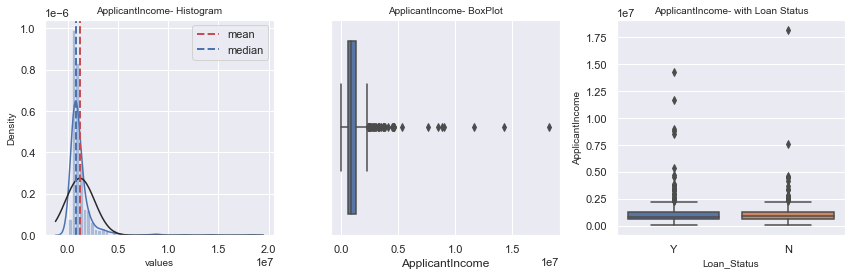

In [24]:
visualise_features(data_df,'ApplicantIncome','continous')

#### Inferences:

1. From the above summary and plots it can be inferred that the Applicant Income for most of the applicants lies towards the 
   left.
2. It is Highly skewed due to the presence of outliers.

### Hypothesis Testing:
1. We can use two sample T test to check if the mean income of applicant for which loan is approved is different as   compared to the mean income of applicant for whihc the loan is not approved.
2. M1:Mean of Applicant income when Loan_Status='Y' Approved
   M2:Mean of Applicant income when Loan_Status='N' Not Approved

3. Null Hypothesis: M1=M2
   Alternate Hypothesis: M1 != M2
4. Significance level of alpha= 0.05

In [25]:
two_sample_ttest(data_df,['ApplicantIncome'])

,Numeric_Feature,M1_Loan_Status_Yes,M2_Loan_Status_No,T_Stat,P_value
0,ApplicantIncome,1.207635e+06,1.277224e+06,-0.50764,0.611922


1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. M1 is nearly equal to M2 

#### Create bins for the Income and check the relation between the various income category with the target variable

In [26]:
income_label=['Low','Average','High','Very_High']
#bins are created by taking the values of income from the 5 point summary
#min,Q1,Q2,Q3,Upper_whisker,max
income_bins=[33000.0, 647000.0, 1300000.0, 2262000.0,20000000.0]
data_df['Applicant_Income_category'] = pd.cut(data_df['ApplicantIncome'],bins=income_bins,labels=income_label)
data_df['Applicant_Income_category'] = data_df.Applicant_Income_category.astype('object')

In [27]:
data_df['Loan_Status'].value_counts(normalize=True)

Y    0.68714
N    0.31286
Name: Loan_Status, dtype: float64

In [28]:
data_df['Loan_Status'].value_counts()

Y    358
N    163
Name: Loan_Status, dtype: int64

In [29]:
custom_summary_func2(data_df,'Applicant_Income_category')

,Applicant_Income_category,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,Average,261,0.500960,0.685824,0.314176
1,Low,131,0.251440,0.702290,0.297710
2,High,86,0.165067,0.697674,0.302326
3,Very_High,43,0.082534,0.627907,0.372093


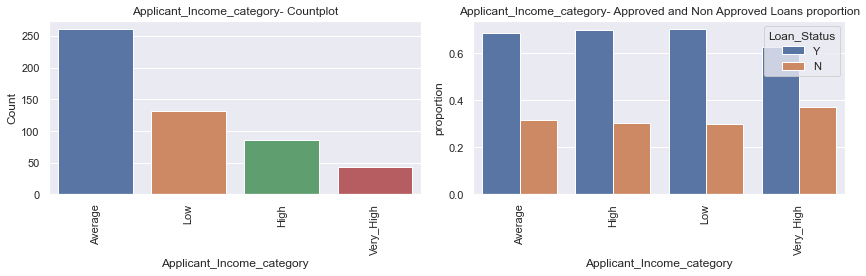

In [30]:
visualise_features(data_df,'Applicant_Income_category','discrete')

#### Inferences:

1. From the above summary and plots it can be inferred that there are more number of Applicants with low and Average   income.
2. Even the Very High Income applicants have loan rejections(~37%).
3. The Approvals are higher for the Low,Average and High category.
4. The Probaility of Loan approval when there is no independent variable = 0.68714
5. The Probaility of Loan approval when the independent variable is present differs roughly about 6%. But we can check this after doing a statistical test. 

### Hypothesis Testing:
1. We can use two chi square test to check if the applicant income is associated with the target variable.
2. P1=P(Approval):0.68714
   P2=P(Approval/Applicant Income):      
3. Null Hypothesis: P1=P2. There is no association between the ind.variable and target variable.
   Alternate Hypothesis: P1 != P2
4. Significance level of alpha= 0.05

In [31]:
chi2_summary(data_df,['Applicant_Income_category'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Applicant_Income_category,0.888141,0.828289,3


1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. There is no association between the ind.variable and target variable.

##### 2. Co-Applicat Income: Income of the co-applicant

In [32]:
summary_df[summary_df['Feature_Name']=='CoapplicantIncome']

,Feature_Name,Count,lower_whisker,min,Q1,Q2,Q3,upper_whisker,max,mean,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
2,CoapplicantIncome,521,-776925.0,0.0,0.0,281250.0,517950.0,1294875.0,4500000.0,349599.437615,2.327384e+11,482429.638597,3.407483,21.802435,Highly positively skewed,Leptokurtic,Has Outliers


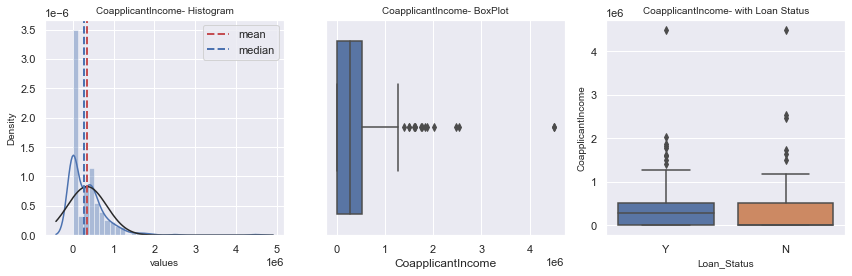

In [33]:
visualise_features(data_df,'CoapplicantIncome','continous')

#### Inferences:

1. From the above summary and plots it can be inferred that the Co-Applicant Income for most of the applicants lies towards the 
   left.
2. It is Highly skewed due to the presence of outliers.
3. There are more number of records where the co applicants income is zero.

### Hypothesis Testing:
1. We can use two sample T test to check if the mean income of coapplicant for which loan is approved is different as   compared to the mean income of coapplicant for whihc the loan is not approved.
2. M1:Mean of CoApplicant income when Loan_Status='Y' Approved
   M2:Mean of CoApplicant income when Loan_Status='N' Not Approved

3. Null Hypothesis: M1=M2
   Alternate Hypothesis: M1 != M2
4. Significance level of alpha= 0.05

In [34]:
two_sample_ttest(data_df,['CoapplicantIncome'])

,Numeric_Feature,M1_Loan_Status_Yes,M2_Loan_Status_No,T_Stat,P_value
0,CoapplicantIncome,347726.136864,353713.803681,-0.131229,0.895645


### Results:
1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. M1 is nearly equal to M2 

#### Create bins for the CoApplicant Income and check the relation between the various income category with the target variable

In [35]:
income_label_1=['Low','Average','High','Very_High']
income_bins_1=[0, 290000.0, 520000.0,1300000.0,4500000.0]
data_df['Co_Applicant_Income_category']=pd.cut(data_df['CoapplicantIncome'],bins=income_bins_1,labels=income_label_1,include_lowest=True)

In [36]:
data_df['Co_Applicant_Income_category'] = data_df.Co_Applicant_Income_category.astype('object')
custom_summary_func2(data_df,'Co_Applicant_Income_category')

,Co_Applicant_Income_category,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,Low,266,0.510557,0.672932,0.327068
1,Average,125,0.239923,0.720000,0.280000
2,High,115,0.220729,0.695652,0.304348
3,Very_High,15,0.028791,0.600000,0.400000


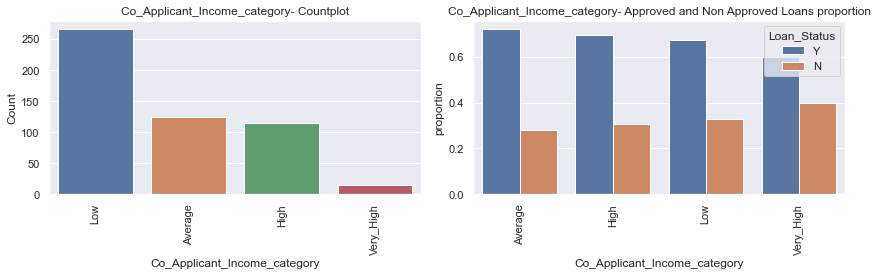

In [37]:
visualise_features(data_df,'Co_Applicant_Income_category','discrete')

#### Inferences:

1. From the above summary and plots it can be inferred that there are more number of CoApplicants with Low and Average income.
2. There are more number of people where the income is 0. It could be possible that the co applicant was not actually present and the Co applicant income was set to 0.
3. Even the High Income Coapplicants have loan rejections.
4. We cant say that as the income increases the chances of approval inccrease.
5. Among all the categories Low,Average and High income range applicants have the highest approval percentage.  

### Hypothesis Testing:
1. We can use two chi square test to check if the coapplicant income is associated with the target variable.
2. P1=P(Approval):0.68714
   P2=P(Approval/CoApplicant Income):      
3. Null Hypothesis: P1=P2. There is no association between the ind.variable and target variable.
   Alternate Hypothesis: P1 != P2
4. Significance level of alpha= 0.05

In [38]:
chi2_summary(data_df,['Co_Applicant_Income_category'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Co_Applicant_Income_category,1.44619,0.694744,3


### Results
1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. There is no association between the ind.variable and target variable.

#### 3. Create combined income feature Total_income

In [39]:
data_df['Total_Income']=data_df['ApplicantIncome']+data_df['CoapplicantIncome']

In [40]:
summary_df_new=custom_summary_func1(data_df)
summary_df_new[summary_df_new['Feature_Name']=='Total_Income']

,Feature_Name,Count,lower_whisker,min,Q1,Q2,Q3,upper_whisker,max,mean,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
6,Total_Income,521,-202050.0,324450.0,937350.0,1199925.0,1696950.0,2836350.0,18225000.0,1.579006e+06,2.175610e+12,1.474995e+06,5.864907,48.919802,Highly positively skewed,Leptokurtic,Has Outliers


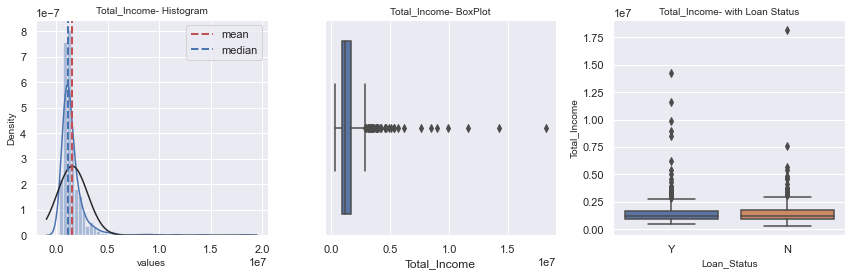

In [41]:
visualise_features(data_df,'Total_Income','continous')

### Hypothesis Testing:
1. We can use two sample T test to check if the mean Totalincome of applicant for which loan is approved is different as   compared to the mean Totalincome of applicant for whihc the loan is not approved.
2. M1:Mean of Applicant Totalincome when Loan_Status='Y' Approved
   M2:Mean of Applicant Totalincome when Loan_Status='N' Not Approved

3. Null Hypothesis: M1=M2
   Alternate Hypothesis: M1 != M2
4. Significance level of alpha= 0.05

In [42]:
two_sample_ttest(data_df,['Total_Income'])

,Numeric_Feature,M1_Loan_Status_Yes,M2_Loan_Status_No,T_Stat,P_value
0,Total_Income,1.555361e+06,1.630938e+06,-0.541903,0.588118


### Results
1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. M1 is nearly equal to M2 

### Create bins for Total Income

In [43]:
income_label_2=['Low','Average','High','Very_High']
income_bins_2=[320000.0, 938000.0, 1700000.0, 2900000.0,20000000.0]
data_df['Total_Income_category']=pd.cut(data_df['Total_Income'],bins=income_bins_2,labels=income_label_2)

In [44]:
data_df['Total_Income_category'] = data_df.Total_Income_category.astype('object')
custom_summary_func2(data_df,'Total_Income_category')

,Total_Income_category,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,Average,262,0.502879,0.698473,0.301527
1,Low,131,0.251440,0.679389,0.320611
2,High,87,0.166987,0.712644,0.287356
3,Very_High,41,0.078695,0.585366,0.414634


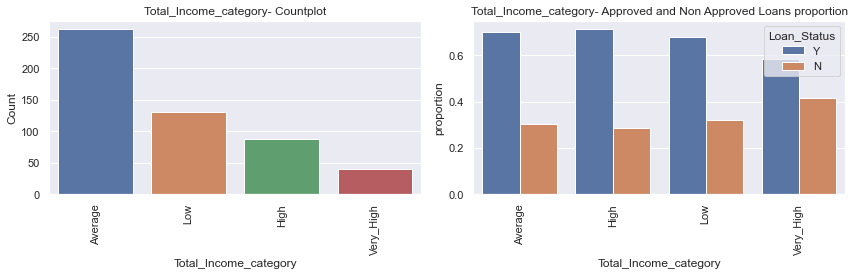

In [45]:
visualise_features(data_df,'Total_Income_category','discrete')

#### Inferences:

1. There more applicants in the low and average income range.
2. The Percentage of approvals are alsmost similar forall ranges of applicants.

### Hypothesis Testing:
1. We can use two chi square test to check if the Total_Income_category is associated with the target variable.
2. P1=P(Approval):0.68714
   P2=P(Approval/Applicant Income):      
3. Null Hypothesis: P1=P2. There is no association between the ind.variable and target variable.
   Alternate Hypothesis: P1 != P2
4. Significance level of alpha= 0.05

In [46]:
chi2_summary(data_df,['Total_Income_category'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Total_Income_category,2.431809,0.487741,3


### Results
1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. There is no association between the ind.variable and target variable.

##### 4. LoanAmount: Amount of loan applicant wants to issue from the bank.

In [47]:
summary_df[summary_df['Feature_Name']=='LoanAmount']

,Feature_Name,Count,lower_whisker,min,Q1,Q2,Q3,upper_whisker,max,mean,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
3,LoanAmount,521,10000.0,0.0,196000.0,250000.0,320000.0,506000.0,1400000.0,279704.414587,2.932674e+10,171250.50522,2.485041,10.372368,Highly positively skewed,Leptokurtic,Has Outliers


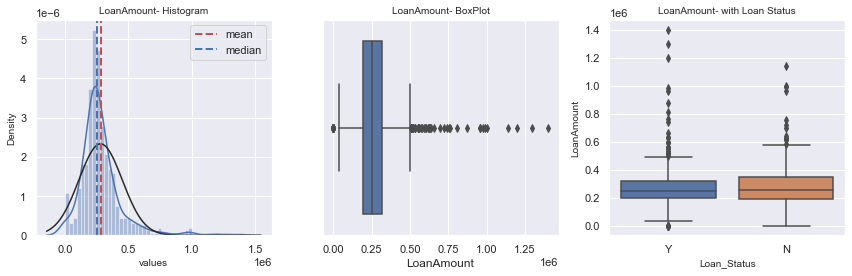

In [48]:
visualise_features(data_df,'LoanAmount','continous')

#### Inferences:

1. From the above summary and plots it can be inferred that the distribution is skewed and has outliers.
2. But the difference beyween the mean and median is not as huge as the applicants income

### Hypothesis Testing:
1. We can use two sample T test to check if the mean LoanAmount of applicant for which loan is approved is different as  compared to the mean LoanAmount of applicant for which the loan is not approved.
2. M1:Mean of Applicant LoanAmount when Loan_Status='Y' Approved
   M2:Mean of Applicant LoanAmount when Loan_Status='N' Not Approved
3. Null Hypothesis: M1=M2
   Alternate Hypothesis: M1 != M2
4. Significance level of alpha= 0.05

In [49]:
two_sample_ttest(data_df,['LoanAmount'])

,Numeric_Feature,M1_Loan_Status_Yes,M2_Loan_Status_No,T_Stat,P_value
0,LoanAmount,274463.687151,291214.723926,-1.035276,0.301022


### Results:
1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. M1 is nearly equal to M2 

### Create bins for Loan Amount-- Loan_Amount category

In [50]:
loan_amount_labels=['Low','Average','High','Very_High']
loan_amount_bins=[0.0, 200000.0, 320000.0,506000.0,1500000.0]
data_df['Loan_Amount_category']=pd.cut(data_df['LoanAmount'],bins=loan_amount_bins,labels=loan_amount_labels,include_lowest=True)

In [51]:
data_df['Loan_Amount_category'] = data_df.Loan_Amount_category.astype('object')
custom_summary_func2(data_df,'Loan_Amount_category')

,Loan_Amount_category,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,Average,243,0.466411,0.720165,0.279835
1,Low,150,0.287908,0.680000,0.320000
2,High,88,0.168906,0.670455,0.329545
3,Very_High,40,0.076775,0.550000,0.450000


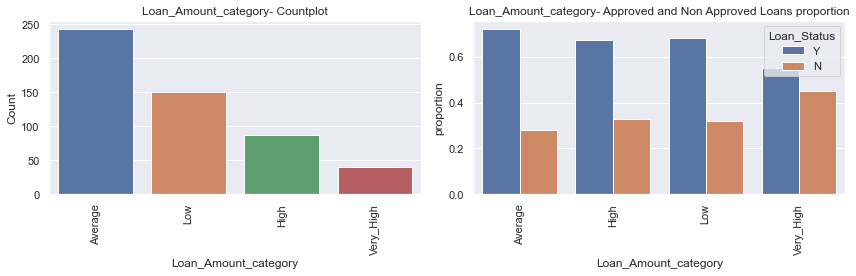

In [52]:
visualise_features(data_df,'Loan_Amount_category','discrete')

#### Inferences:
1. The Approval percentages are high for Low,Average and High Loan amount category.
2. The approvals dont decrease as the Loan Amount increase.

### Hypothesis Testing:
1. We can use two chi square test to check if the Loan amount category is associated with the target variable.
2. P1=P(Approval):0.68714
   P2=P(Approval/Loan amount category Income):      
3. Null Hypothesis: P1=P2. There is no association between the ind.variable and target variable.
   Alternate Hypothesis: P1 != P2
4. Significance level of alpha= 0.05

In [53]:
chi2_summary(data_df,['Loan_Amount_category'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Loan_Amount_category,4.881712,0.180667,3


### Results
1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. There is no association between the ind.variable and target variable.

##### 4. Loan_Amount_Term: The amount of time the lender gives you to repay your whole loan

In [54]:
summary_df[summary_df['Feature_Name']=='Loan_Amount_Term']

,Feature_Name,Count,lower_whisker,min,Q1,Q2,Q3,upper_whisker,max,mean,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
4,Loan_Amount_Term,521,360.0,12.0,360.0,360.0,360.0,360.0,480.0,343.715931,3944.38,62.804305,-2.376678,7.206502,Highly negatively skewed,Leptokurtic,Has Outliers


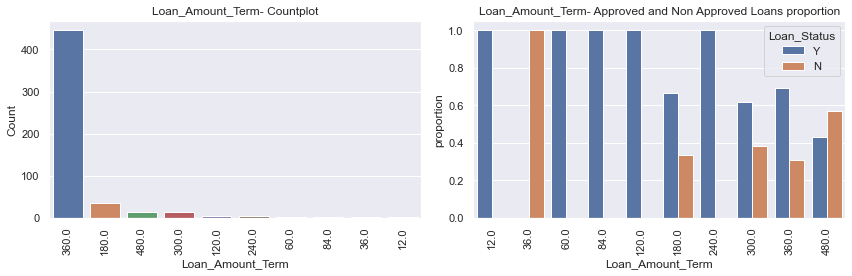

In [55]:
visualise_features(data_df,'Loan_Amount_Term','discrete')

### Hypothesis Testing:
1. We can use two sample T test to check if the mean Loan_Amount_Term for which loan is approved is different as compared to the mean Loan_Amount_Term for which the loan is not approved.
2. M1:Mean of Loan_Amount_Term when Loan_Status='Y' Approved
   M2:Mean of Loan_Amount_Term when Loan_Status='N' Not Approved
3. Null Hypothesis: M1=M2
   Alternate Hypothesis: M1 != M2
4. Significance level of alpha= 0.05

In [56]:
two_sample_ttest(data_df,['Loan_Amount_Term'])

,Numeric_Feature,M1_Loan_Status_Yes,M2_Loan_Status_No,T_Stat,P_value
0,Loan_Amount_Term,341.396648,348.809816,-1.249872,0.21191


### Results
1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. M1 is nearly equal to M2 

In [57]:
data_df['Loan_Amount_Term_yrs'] = data_df['Loan_Amount_Term'].apply(lambda x: x/12)
data_df['Loan_Amount_Term_yrs'] = data_df['Loan_Amount_Term_yrs'].astype('object')

In [58]:
months_labels=['Low','Average','High']
months_bins=[1,10,25,40]
data_df['Loan_Amount_Term_yrs_category']=pd.cut(data_df['Loan_Amount_Term_yrs'],bins=months_bins,labels=months_labels,include_lowest=True)

In [59]:
data_df['Loan_Amount_Term_yrs_category'] = data_df['Loan_Amount_Term_yrs_category'].astype('object')
custom_summary_func2(data_df,'Loan_Amount_Term_yrs_category')

,Loan_Amount_Term_yrs_category,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,High,460,0.882917,0.684783,0.315217
1,Average,52,0.099808,0.673077,0.326923
2,Low,9,0.017274,0.888889,0.111111


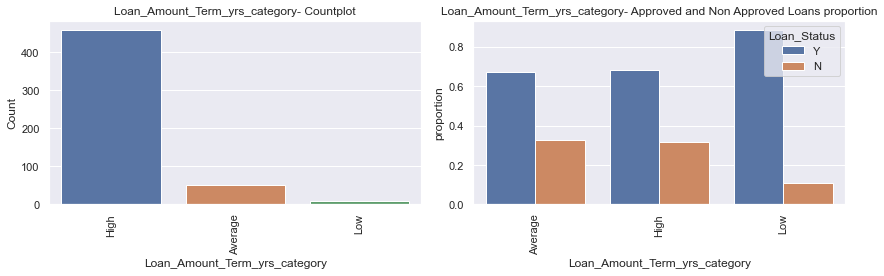

In [60]:
visualise_features(data_df,'Loan_Amount_Term_yrs_category','discrete')

#### Inferences:

1. There are many applicants who applied for 3 years.
2. It was Hypothesised that the approvals will be more for the longer loan terms. But from the data we can observe that 
   it is not completly true.
3. Also there are very few applicants who applied for shorter duration like 12,36,60,84,120 and 240 months respectively.
4. The other applicants who applied for 180,300,360,480 months the approvals are less if the laon duration is increased.

### Hypothesis Testing:
1. We can use two chi square test to check if the Loan_Amount_Term_yrs_category is associated with the target variable.
2. P1=P(Approval):0.68714
   P2=P(Approval/Loan_Amount_Term_yrs_category):      
3. Null Hypothesis: P1=P2. There is no association between the ind.variable and target variable.
   Alternate Hypothesis: P1 != P2
4. Significance level of alpha= 0.05

In [61]:
chi2_summary(data_df,['Loan_Amount_Term_yrs_category'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Loan_Amount_Term_yrs_category,1.763729,0.41401,2


### Results
1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. There is no association between the ind.variable and target variable.

#### 5.Credit_History:It tells about the credit done in the past by the applicant.

In [62]:
summary_df[summary_df['Feature_Name']=='Credit_History']

,Feature_Name,Count,lower_whisker,min,Q1,Q2,Q3,upper_whisker,max,mean,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
5,Credit_History,521,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.859885,0.12,0.34744,-2.07962,2.333764,Highly negatively skewed,Leptokurtic,Has Outliers


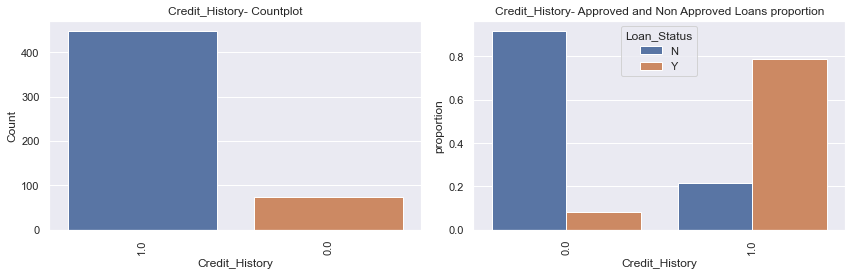

In [63]:
visualise_features(data_df,'Credit_History','discrete')

#### Inferences:

1. There applicants who have credit history have higher chances for loan approvals.

In [64]:
data_df['Credit_History'] = data_df['Credit_History'].astype('object')
custom_summary_func2(data_df,'Credit_History')

,Credit_History,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,1.0,448,0.859885,0.785714,0.214286
1,0.0,73,0.140115,0.082192,0.917808


### Hypothesis Testing:
1. We can use two chi square test to check if the Credit_History is associated with the target variable.
2. P1=P(Approval):0.68714
   P2=P(Approval/Credit_History):      
3. Null Hypothesis: P1=P2. There is no association between the ind.variable and target variable.
   Alternate Hypothesis: P1 != P2
4. Significance level of alpha= 0.05

In [65]:
chi2_summary(data_df,['Credit_History'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Credit_History,141.264672,1.408211e-32,1


### Results
1. The P value is <0.05.
2. We reject the Null Hypothesis.
3. There is association between the ind.variable and target variable.

#### Target Variable

#### 6. Loan_Status:It is a target variable column which tells about whether the applicant application for loan approval is passed or not.

Text(0.5, 1.0, 'Approved and Non Approved Loans Count')

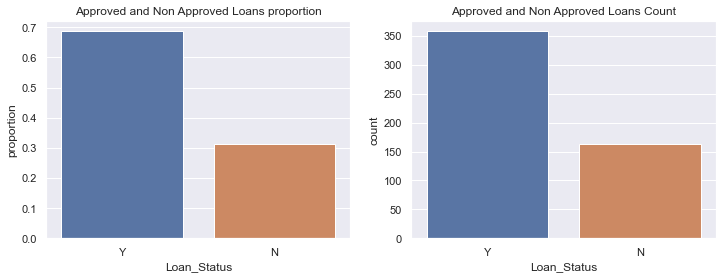

In [66]:
sns.set_theme(style="darkgrid")
f,(axes) = plt.subplots(1,2 ,figsize=(12,4))
proportion_of_approvals = data_df['Loan_Status'].value_counts(normalize=True)
graph1=sns.barplot(x=proportion_of_approvals.index, y=proportion_of_approvals,ax=axes[0])
graph1.set_xlabel('Loan_Status')
graph1.set_ylabel('proportion')
graph1.set_title('Approved and Non Approved Loans proportion')

graph2=sns.countplot(data_df['Loan_Status'],ax=axes[1])
graph2.set_xlabel('Loan_Status')
graph2.set_ylabel('count')
graph2.set_title('Approved and Non Approved Loans Count')

In [67]:
print(data_df['Loan_Status'].value_counts(normalize=True))
print(data_df['Loan_Status'].value_counts())

Y    0.68714
N    0.31286
Name: Loan_Status, dtype: float64
Y    358
N    163
Name: Loan_Status, dtype: int64


#### Inferences:

1. Around 68% of the loans are approved
2. #358 Loans are approved out of 521

#### Categorical Variables:  
##### Nominal Variables
1. Gender
2. Married
3. Self Employed

##### Ordinal variables
1. Dependents
2. Education
3. Property_Area


#### 7. Gender: Gender of a applicant whether male or female

In [68]:
custom_summary_func2(data_df,'Gender')

,Gender,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,Male,425,0.815739,0.691765,0.308235
1,Female,96,0.184261,0.666667,0.333333


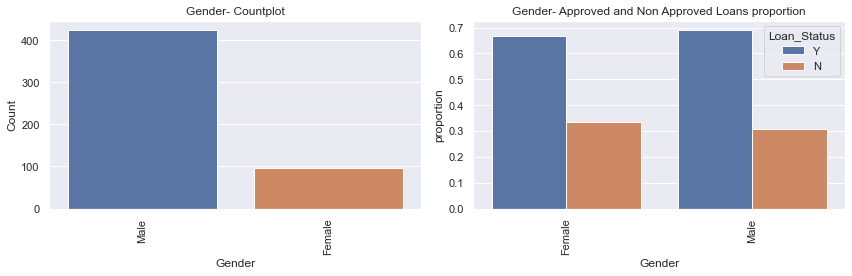

In [69]:
visualise_features(data_df,'Gender','discrete')

#### Inferences:

1. There are more Male applicants(81.5%) than the Female applicants(18.4%).
2. The Approvals and rejections are almost similar for both the genders.

### Hypothesis Testing:
1. We can use two chi square test to check if the Gender is associated with the target variable.
2. P1=P(Approval):0.68714
   P2=P(Approval/Gender):      
3. Null Hypothesis: P1=P2. There is no association between the ind.variable and target variable.
   Alternate Hypothesis: P1 != P2
4. Significance level of alpha= 0.05

In [70]:
chi2_summary(data_df,['Gender'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Gender,0.127563,0.720972,1


### Results
1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. There is no association between the ind.variable and target variable.

#### 8. Married: Martial status of a applicant i.e., Yes for married and No for single

In [71]:
custom_summary_func2(data_df,'Married')

,Married,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,Yes,338,0.648752,0.718935,0.281065
1,No,183,0.351248,0.628415,0.371585


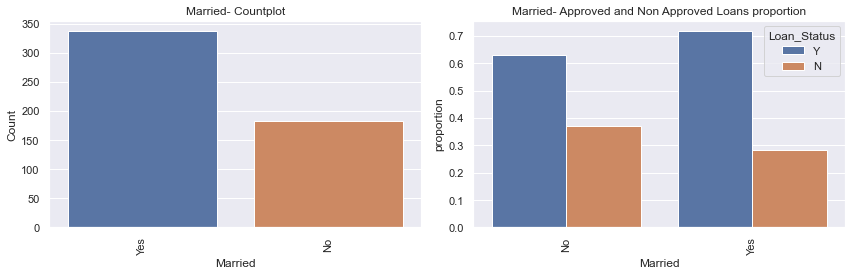

In [72]:
visualise_features(data_df,'Married','discrete')

#### Inferences:

1. There are more Married applicants(65%) than the unmarried applicants(35%).
2. The Proportion of Approvals are higher for married applicants.

### Hypothesis Testing:
1. We can use two chi square test to check if the Married is associated with the target variable.
2. P1=P(Approval):0.68714
   P2=P(Approval/Married):      
3. Null Hypothesis: P1=P2. There is no association between the ind.variable and target variable.
   Alternate Hypothesis: P1 != P2
4. Significance level of alpha= 0.05


In [73]:
chi2_summary(data_df,['Married'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Married,4.113749,0.042536,1


### Results
1. The P value is <0.05.
2. We reject the Null Hypothesis.
3. There is association between the ind.variable and target variable.

#### 9. Self Employed: Whether the applicant is self employed or not i.e, Yes for self employed or else No

In [74]:
custom_summary_func2(data_df,'Self_Employed')

,Self_Employed,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,No,454,0.871401,0.687225,0.312775
1,Yes,67,0.128599,0.686567,0.313433


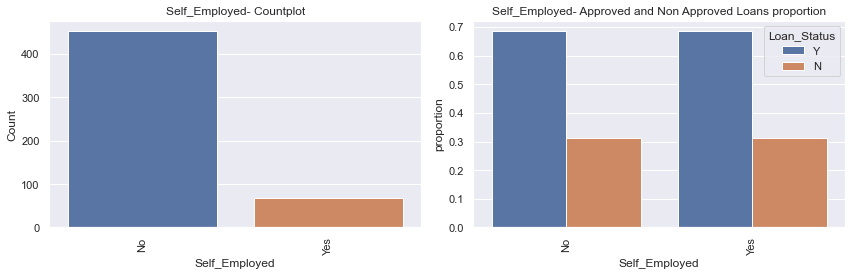

In [75]:
visualise_features(data_df,'Self_Employed','discrete')

#### Inferences:

1. There are more applicants(87%) who are not self employed than the self employed applicants(13%).
2. The Approvals and rejections are almost similar for both the self employed and not self employed.

### Hypothesis Testing:
1. We can use two chi square test to check if the Self_Employed is associated with the target variable.
2. P1=P(Approval):0.68714
   P2=P(Approval/Self_Employed):      
3. Null Hypothesis: P1=P2. There is no association between the ind.variable and target variable.
   Alternate Hypothesis: P1 != P2
4. Significance level of alpha= 0.05

In [76]:
chi2_summary(data_df,['Self_Employed'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Self_Employed,0.0,1.0,1


### Results
1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. There is no association between the ind.variable and target variable.

#### 10. Dependents: Number of individuals who are financially dependent on applicant

In [77]:
custom_summary_func2(data_df,'Dependents')

,Dependents,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,0,312,0.598848,0.685897,0.314103
1,1,84,0.161228,0.619048,0.380952
2,2,84,0.161228,0.785714,0.214286
3,3+,41,0.078695,0.634146,0.365854


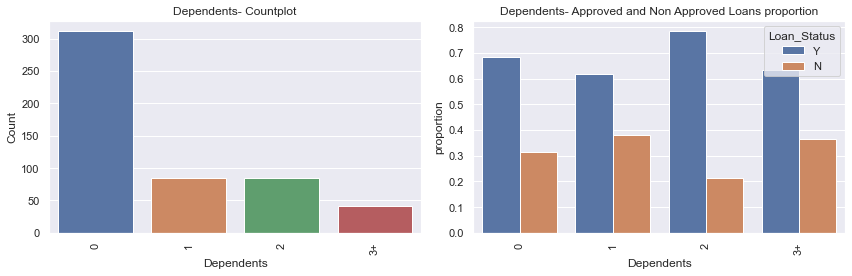

In [78]:
visualise_features(data_df,'Dependents','discrete')

#### Inferences:

1. There are more applicants(87%) who do not have dependents.
2. The proportion of approvals and Not approvals is approximatly 65% to 35%.

### Hypothesis Testing:
1. We can use two chi square test to check if the Dependents is associated with the target variable.
2. P1=P(Approval):0.68714
   P2=P(Approval/Dependents):      
3. Null Hypothesis: P1=P2. There is no association between the ind.variable and target variable.
   Alternate Hypothesis: P1 != P2
4. Significance level of alpha= 0.05

In [79]:
chi2_summary(data_df,['Dependents'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Dependents,6.146259,0.104707,3


### Results
1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. There is no association between the ind.variable and target variable.

### Create bins for Dependents

In [80]:
data_df["Dependents"].replace("3+",3,inplace=True)

In [81]:
##Dependents Range
dep_bins=[0,1,2,3]
dep_labels=["0 to 1","1 to 2","2 to 3"]
data_df['Dependents_Range'] = pd.cut(data_df["Dependents"],bins=dep_bins,labels=dep_labels,include_lowest=True)
data_df['Dependents_Range'] = data_df['Dependents_Range'].astype('object')

In [82]:
custom_summary_func2(data_df,'Dependents_Range')

,Dependents_Range,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,0 to 1,396,0.760077,0.671717,0.328283
1,1 to 2,84,0.161228,0.785714,0.214286
2,2 to 3,41,0.078695,0.634146,0.365854


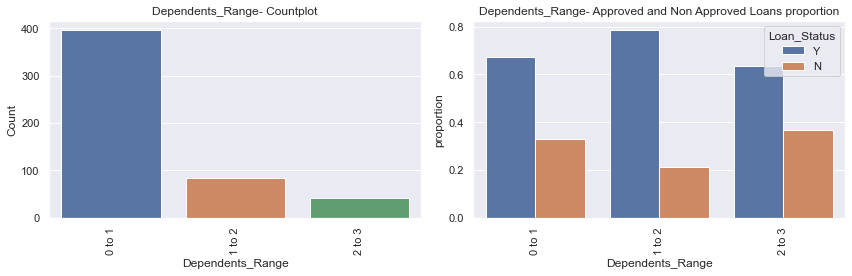

In [83]:
visualise_features(data_df,'Dependents_Range','discrete')

In [84]:
chi2_summary(data_df,['Dependents_Range'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Dependents_Range,4.770495,0.092066,2


### Results
1. The P value is >0.05.
2. We reject the Null Hypothesis.
3. There is no association between the ind.variable and target variable.

#### 11. Education: Highest Education of applicant i.e, Bachelor, Post Graduation etc.,

In [85]:
custom_summary_func2(data_df,'Education')

,Education,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,Graduate,408,0.783109,0.713235,0.286765
1,Not Graduate,113,0.216891,0.592920,0.407080


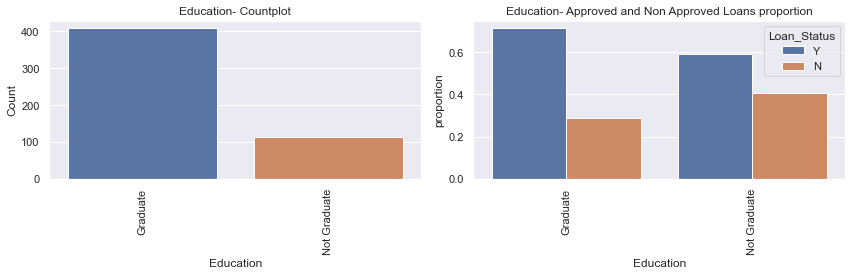

In [86]:
visualise_features(data_df,'Education','discrete')

#### Inferences:

1. There are more applicants who are graduates(78.3%) than the Non Graduate applicants(21.6%).
2. The Approvals for the Loan are 10% higher for the Graduate applicants as compared to Non Graduate applicants.

### Hypothesis Testing:
1. We can use two chi square test to check if the Education is associated with the target variable.
2. P1=P(Approval):0.68714
   P2=P(Approval/Education):      
3. Null Hypothesis: P1=P2. There is no association between the ind.variable and target variable.
   Alternate Hypothesis: P1 != P2
4. Significance level of alpha= 0.05

In [87]:
chi2_summary(data_df,['Education'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Education,5.412089,0.019998,1


### Results
1. The P value is <0.05.
2. We reject the Null Hypothesis.
3. There is association between the ind.variable and target variable.

#### 12. Property_Area: This tells about the applicant property is in which area i.e., Rural or Urban

In [88]:
custom_summary_func2(data_df,'Property_Area')

,Property_Area,Count,Proportion,Proportion_Loan_Status_Y,Proportion_Loan_Status_N
0,Semiurban,197,0.378119,0.786802,0.213198
1,Urban,176,0.337812,0.653409,0.346591
2,Rural,148,0.284069,0.594595,0.405405


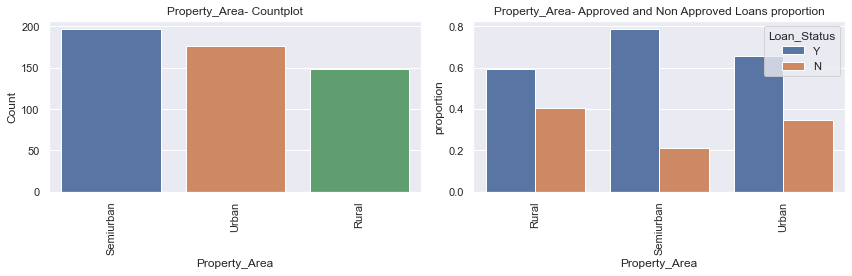

In [89]:
visualise_features(data_df,'Property_Area','discrete')

#### Inferences:

1. There are more applicants who live in Semiurban areas.
2. The Approvals for the Loan are 18% higher for the applicants in Semi urban areas as compared to Rural areas.
3. The Approvals for the Loan are 13% higher for the applicants in Semi urban areas as compared to Urban areas.
4. The Approvals for the Loan are greater for the applicants in Semi urban areas as compared to Rural and Urban areas.

### Hypothesis Testing:
1. We can use two chi square test to check if the Property_Area is associated with the target variable.
2. P1=P(Approval):0.68714
   P2=P(Approval/Property_Area):      
3. Null Hypothesis: P1=P2. There is no association between the ind.variable and target variable.
   Alternate Hypothesis: P1 != P2
4. Significance level of alpha= 0.05

In [90]:
chi2_summary(data_df,['Property_Area'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Property_Area,15.929602,0.000347,2


### Results
1. The P value is >0.05.
2. We fail to reject the Null Hypothesis.
3. There is no association between the ind.variable and target variable.

<AxesSubplot:>

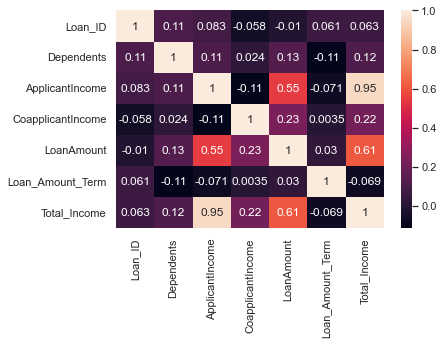

In [91]:
correlation=data_df.corr()
fig = plt.figure(figsize=(6,4))
sns.heatmap(correlation,annot=True,linecolor='white')

#### Inferences:
The correlations are more for the following pairs
1. Applicant income and Loan Amount
2. Co Applicant Income and the Loan Amount
3. Total income and the Loan Amount
4. Applicant income, Co Applicant Income with the Total_Income
5. We can choose to include the (Total_Income) or (Applicant and Co Applicant Income)

In [92]:
chi2_summary(data_df,['Gender','Married','Self_Employed','Dependents','Education','Property_Area','Credit_History'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Gender,0.127563,7.209722e-01,1
1,Married,4.113749,4.253597e-02,1
2,Self_Employed,0.000000,1.000000e+00,1
3,Dependents,6.146259,1.047072e-01,3
4,Education,5.412089,1.999777e-02,1
5,Property_Area,15.929602,3.474808e-04,2
6,Credit_History,141.264672,1.408211e-32,1


In [93]:
two_sample_ttest(data_df,['ApplicantIncome','CoapplicantIncome','Total_Income','LoanAmount','Loan_Amount_Term'])

,Numeric_Feature,M1_Loan_Status_Yes,M2_Loan_Status_No,T_Stat,P_value
0,ApplicantIncome,1.207635e+06,1.277224e+06,-0.507640,0.611922
1,CoapplicantIncome,3.477261e+05,3.537138e+05,-0.131229,0.895645
2,Total_Income,1.555361e+06,1.630938e+06,-0.541903,0.588118
3,LoanAmount,2.744637e+05,2.912147e+05,-1.035276,0.301022
4,Loan_Amount_Term,3.413966e+02,3.488098e+02,-1.249872,0.211910


In [94]:
chi2_summary(data_df,['Applicant_Income_category','Co_Applicant_Income_category','Total_Income_category', 'Loan_Amount_category','Loan_Amount_Term_yrs_category'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Applicant_Income_category,0.888141,0.828289,3
1,Co_Applicant_Income_category,1.446190,0.694744,3
2,Total_Income_category,2.431809,0.487741,3
3,Loan_Amount_category,4.881712,0.180667,3
4,Loan_Amount_Term_yrs_category,1.763729,0.414010,2


### Feature Engineering

#### EMI Calculation
1. Assuming the rate of interest = 10%
2. To calculate the rate of interest per month = (10/100)/12 = 0.0083
3. EMI formula : EMI = [P x R x (1+R) ^ N] / [(1+R) ^ (N-1)]
4. N = loan amount term in months
5. P = Principle amount

In [95]:
R=0.0083
data_df["EMI"]=data_df.apply(lambda data_df:(((data_df['LoanAmount'] * R * (1+R) ** data_df['Loan_Amount_Term'])) / ((1+R) ** (data_df['Loan_Amount_Term']-1))),axis=1)

### Balance Income: Total Income - EMI

In [96]:
data_df["Monthly_Balance_Income"]=(data_df["Total_Income"]/12)-data_df["EMI"]

### DTI : Debt to Income ratio : Month EMI / Monthly gross Income

In [97]:
data_df['DTI'] = data_df['EMI'] / (data_df['Total_Income']/12 )

In [98]:
two_sample_ttest(data_df,['EMI','Monthly_Balance_Income','DTI'])

,Numeric_Feature,M1_Loan_Status_Yes,M2_Loan_Status_No,T_Stat,P_value
0,EMI,2296.956407,2437.143991,-1.035276,0.301022
1,Monthly_Balance_Income,127316.447224,133474.359077,-0.533622,0.593831
2,DTI,0.020110,0.020994,-1.138021,0.255637


### Capacity: ((TotalIncome/LoanAmount)>1) and (credit history =1)

In [99]:
### Creating the combined features
data_df["Capacity"] = ((data_df["Total_Income"]/data_df["LoanAmount"])>0.5) & (data_df['Credit_History']==1)
data_df["Capacity"] = data_df["Capacity"].map({True:1,False:0})

### Capital in Urban and SemiUrban and credit history =1

In [100]:
data_df["Applicant_Capital"] = ((data_df["Property_Area"].isin(["Urban","Semiurban"])) & (data_df["Credit_History"]==1))
data_df["Applicant_Capital"] = data_df["Applicant_Capital"].map({True:1,False:0})

In [101]:
data_df["Gender_M_with_Credithistory"] = ((data_df["Gender"].isin(["Male"])) & (data_df["Credit_History"]==1))
data_df["Gender_M_with_Credithistory"] = data_df["Gender_M_with_Credithistory"].map({True:1,False:0})

In [102]:
data_df["Gender_F_with_Credithistory"] = ((data_df["Gender"].isin(["Female"])) & (data_df["Credit_History"]==1))
data_df["Gender_F_with_Credithistory"] = data_df["Gender_F_with_Credithistory"].map({True:1,False:0})

In [103]:
data_df["Gender_M_Married"] = ((data_df["Gender"].isin(["Male"])) & (data_df["Married"]=='Yes'))
data_df["Gender_M_Married"] = data_df["Gender_M_Married"].map({True:1,False:0})

In [104]:
data_df["Gender_F_Married"] = ((data_df["Gender"].isin(["Female"])) & (data_df["Married"]=='Yes'))
data_df["Gender_F_Married"] = data_df["Gender_F_Married"].map({True:1,False:0})

In [105]:
data_df["Selfemployed_with_Credithistory"] = ((data_df["Self_Employed"].isin(["No"])) & (data_df["Credit_History"]==1))
data_df["Selfemployed_with_Credithistory"] = data_df["Selfemployed_with_Credithistory"].map({True:1,False:0})

In [106]:
data_df["Selfemployed_with_PropertyArea"] = ((data_df["Self_Employed"].isin(["No"])) & (data_df["Property_Area"].isin(["Urban","Semiurban"])))
data_df["Selfemployed_with_PropertyArea"] = data_df["Selfemployed_with_PropertyArea"].map({True:1,False:0})

In [107]:
data_df['Total_Inc_Edu'] = (data_df['Total_Income_category'].isin(['High','Very_High']) & (data_df['Education'] == 'Graduate'))
data_df['Total_Inc_Edu'] =  data_df['Total_Inc_Edu'].map({True:1,False:0})

In [108]:
chi2_summary(data_df,['Capacity','Applicant_Capital','Gender_M_with_Credithistory',
                      'Gender_F_with_Credithistory','Gender_M_Married','Gender_F_Married',
                      'Selfemployed_with_Credithistory','Selfemployed_with_PropertyArea',
                     'Total_Inc_Edu'])

,Categorical_Feature,F_value,P_value,Degrees_of_Freedom
0,Capacity,141.264672,1.408211e-32,1
1,Applicant_Capital,71.882933,2.283504e-17,1
2,Gender_M_with_Credithistory,58.504718,2.028040e-14,1
3,Gender_F_with_Credithistory,2.550065,1.102897e-01,1
4,Gender_M_Married,3.800495,5.123743e-02,1
5,Gender_F_Married,0.000000,1.000000e+00,1
6,Selfemployed_with_Credithistory,66.761296,3.064563e-16,1
7,Selfemployed_with_PropertyArea,5.949448,1.472189e-02,1
8,Total_Inc_Edu,0.020764,8.854243e-01,1


> After analysing the features created after Feature Engineering the below mentioned features 
> have impact on the target variable.

1. Capacity
2. Applicant_Capital
3. Gender_M_with_Credithistory
4. Selfemployed_with_Credithistory
5. Selfemployed_with_PropertyArea

### Ordinal variables
1. Dependents
2. Education
3. Property_Area
4. Dependents_Range

In [109]:
data_df["Dependents"].replace("3+",3,inplace=True)

In [110]:
edu_dict={"Graduate":1,"Not Graduate":0}
data_df["Education"]=data_df["Education"].map(edu_dict)

In [111]:
property_area={"Rural":0,"Semiurban":1,"Urban":2}
data_df["Property_Area"]=data_df["Property_Area"].map(property_area)

"Applicant_Income_category"       
"Co_Applicant_Income_category"    
"Total_Income_category"           
"Loan_Amount_category"            
"Loan_Amount_Term_yrs"            
"Loan_Amount_Term_yrs_category"   
"Dependents_Range"

In [112]:
income_category = {'Low':0,'Average':1,'High':2,'Very_High':3}
data_df["Applicant_Income_category"] = data_df["Applicant_Income_category"].map(income_category)

In [113]:
data_df["Co_Applicant_Income_category"] = data_df["Co_Applicant_Income_category"].map(income_category)

In [114]:
data_df["Total_Income_category"] = data_df["Total_Income_category"].map(income_category)

In [115]:
data_df["Loan_Amount_category"] = data_df["Loan_Amount_category"].map(income_category)

In [116]:
data_df["Loan_Amount_Term_yrs_category"]=data_df["Loan_Amount_Term_yrs_category"].map({'Low':0,'Average':1,'High':2})

In [117]:
data_df["Loan_Amount_Term_yrs"]=data_df["Loan_Amount_Term_yrs"].astype("int")

In [118]:
data_df.drop(["Dependents_Range"],axis=1,inplace=True)

### Nominal variables
1. Gender
2. Married
3. Self Employed

4. Capacity
5. Applicant_Capital
6. Gender_M_with_Credithistory
7. Selfemployed_with_Credithistory
8. Selfemployed_with_PropertyArea

In [119]:
for each_col in ["Gender","Married","Self_Employed","Capacity","Applicant_Capital",
                 "Gender_M_with_Credithistory","Selfemployed_with_Credithistory",
                 "Selfemployed_with_PropertyArea"]:
    dummy_encode(data_df,each_col)

In [120]:
data_df["Credit_History"]=data_df["Credit_History"].astype('uint8')

### Encoding the Target Variable

In [121]:
# Encode the Y Approved as 0 and N Not Approved as 1.
# Since this Loan approval prediction and the importance has to be given to 
# find out consumers whose loan is not approved and likely to default.

Loan_Status={"Y":0,"N":1}
data_df["Loan_Status"]=data_df["Loan_Status"].map(Loan_Status)

In [122]:
def calculate_vif(X):
    '''
    lets try analysisng VIF
    '''
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [123]:
data_df_backup=data_df

In [124]:
data_df = data_df_backup

In [125]:
y=data_df['Loan_Status']
x=data_df.drop("Loan_Status",axis=1)

In [126]:
x=x[[
'Education',
'Property_Area',
'Total_Income_category',
'Loan_Amount_category',
'Applicant_Capital',
'Gender_M_with_Credithistory',
'Gender_M_Married',
'Selfemployed_with_Credithistory',
'Selfemployed_with_PropertyArea'
]]

In [127]:
calculate_vif(x)

,Features,VIF
8,Selfemployed_with_PropertyArea,7.76
1,Property_Area,6.97
4,Applicant_Capital,6.84
5,Gender_M_with_Credithistory,6.70
7,Selfemployed_with_Credithistory,6.28
2,Total_Income_category,4.35
0,Education,4.03
3,Loan_Amount_category,3.96
6,Gender_M_Married,3.30


In [128]:
y.value_counts()

0    358
1    163
Name: Loan_Status, dtype: int64

##### The ratio of both the classes approximatly 2:1 -> This data set is moderatly imbalanced

### Variance threshold to check if any column doesnt have any variance in it.

In [129]:

constant_filter = VarianceThreshold(threshold=0)

#Fit and transforming on the data
data_constant = constant_filter.fit_transform(x)
print(data_constant.shape)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in x.columns
                    if column not in x.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))

#Constant columns names:
for column in constant_columns:
    print(column)

(521, 9)
0


#### There are no columns with 0 variance

#### Train Test split

In [130]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15,random_state=42,stratify=y)

#### Logistic Regression

In [131]:
log_reg= LogisticRegression(random_state=42)
log_reg.fit(x_train,y_train)

LogisticRegression(random_state=42)

In [132]:
y_train_pred_logreg = log_reg.predict(x_train)
y_test_pred_logreg = log_reg.predict(x_test)
print("Training Accuracy={}".format(np.round(accuracy_score(y_train,y_train_pred_logreg),2)))
print("Testing Accuracy={}".format(np.round(accuracy_score(y_test,y_test_pred_logreg),2)))
print(classification_report(y_train,y_train_pred_logreg))

Training Accuracy=0.8
Testing Accuracy=0.76
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       304
           1       0.85      0.43      0.57       138

    accuracy                           0.80       442
   macro avg       0.82      0.70      0.72       442
weighted avg       0.81      0.80      0.78       442



In [133]:
print(classification_report(y_test,y_test_pred_logreg))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84        54
           1       0.71      0.40      0.51        25

    accuracy                           0.76        79
   macro avg       0.74      0.66      0.68        79
weighted avg       0.75      0.76      0.74        79



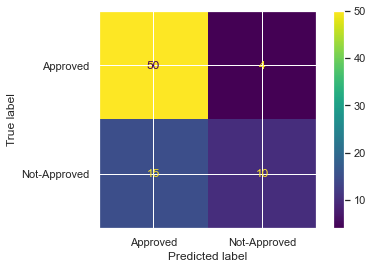

In [134]:
cm = confusion_matrix(y_test, y_test_pred_logreg)
disp=ConfusionMatrixDisplay(cm,display_labels=["Approved", "Not-Approved"])
disp.plot()

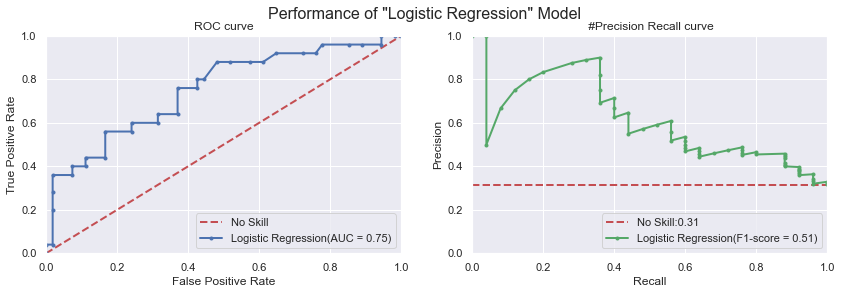

In [135]:
y_test_pred_prob_logreg=log_reg.predict_proba(x_test)
plot_roc_auc_pr_curves(y_test,y_test_pred_prob_logreg[:,1],"Logistic Regression",f1_score(y_test,y_test_pred_logreg))

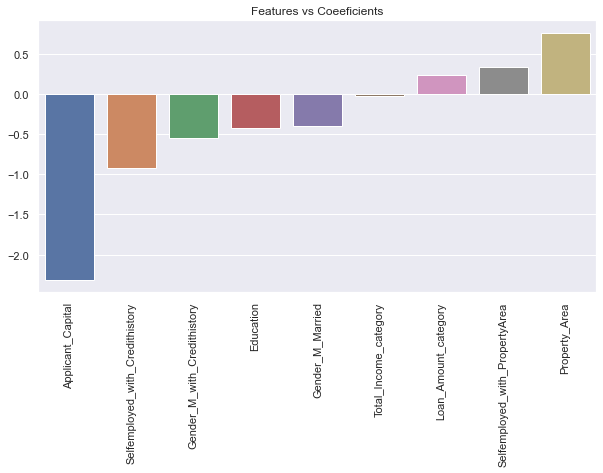

In [136]:
coefficients = pd.Series(index=x_train.columns,data=log_reg.coef_[0]).sort_values()
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,5))
sns.barplot(x=coefficients.index,y=coefficients.values);
plt.title('Features vs Coeeficients');
plt.xticks(rotation=90);

y_test_pred_dec_logreg  = log_reg.decision_function(x_test)

### Decission Tree

In [137]:
dt=DecisionTreeClassifier(random_state=20)
dt.fit(x_train,y_train)

DecisionTreeClassifier(random_state=20)

In [138]:
y_train_pred_dt=dt.predict(x_train)
y_test_pred_dt=dt.predict(x_test)
print("Training Accuracy={}".format(np.round(accuracy_score(y_train,y_train_pred_dt),2)))
print("Testing Accuracy={}".format(np.round(accuracy_score(y_test,y_test_pred_dt),2)))
print(classification_report(y_train,y_train_pred_logreg))

Training Accuracy=0.87
Testing Accuracy=0.76
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       304
           1       0.85      0.43      0.57       138

    accuracy                           0.80       442
   macro avg       0.82      0.70      0.72       442
weighted avg       0.81      0.80      0.78       442



In [139]:
print(classification_report(y_test,y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84        54
           1       0.69      0.44      0.54        25

    accuracy                           0.76        79
   macro avg       0.73      0.67      0.69        79
weighted avg       0.75      0.76      0.74        79



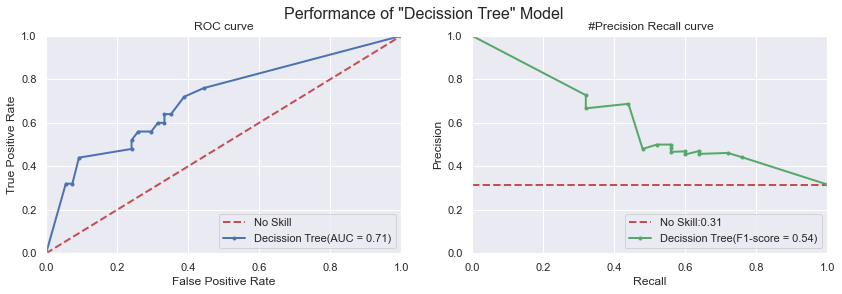

In [140]:
y_test_pred_prob_dt=dt.predict_proba(x_test)
plot_roc_auc_pr_curves(y_test,y_test_pred_prob_dt[:,1],"Decission Tree",f1_score(y_test,y_test_pred_dt))

#### Overfitting case
### Lets control the tree using hyper parameters

In [141]:
hyperparameters_dt = {
                   "criterion": ["entropy", "gini"],
                   "max_depth": [5, 7, 10],
                   "max_features": ["log2", "sqrt"], 
                   'min_samples_leaf' : [5,10,15],
                   'min_samples_split' : [5,10,15]
                   }

In [142]:
grid_search_dt= GridSearchCV(dt,param_grid=hyperparameters_dt,scoring='f1',n_jobs=-1,cv=5)
grid_search_dt.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=20), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 7, 10],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 15]},
             scoring='f1')

In [143]:
best_dt_model_df=pd.DataFrame(grid_search_dt.cv_results_)
best_dt_model_df.to_excel("1_DT_GRID.xlsx")

### After looking at the cv results the below combination of the hyperparameters seem to give good f1score

In [144]:
best_dt_model = DecisionTreeClassifier(criterion='gini',max_depth=10,max_features='sqrt',min_samples_leaf=5,min_samples_split=10,random_state=45)
best_dt_model.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10, random_state=45)

In [145]:
y_train_pred_best_dt = best_dt_model.predict(x_train)
y_test_pred_best_dt = best_dt_model.predict(x_test)

In [146]:
print("Testing Accuracy:", accuracy_score(y_train, y_train_pred_best_dt))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred_best_dt))
print(classification_report(y_train,y_train_pred_best_dt))

Testing Accuracy: 0.7986425339366516
Testing Accuracy: 0.7468354430379747
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       304
           1       0.80      0.48      0.60       138

    accuracy                           0.80       442
   macro avg       0.80      0.71      0.73       442
weighted avg       0.80      0.80      0.78       442



In [147]:
print(classification_report(y_test,y_test_pred_best_dt))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        54
           1       0.65      0.44      0.52        25

    accuracy                           0.75        79
   macro avg       0.71      0.66      0.68        79
weighted avg       0.73      0.75      0.73        79



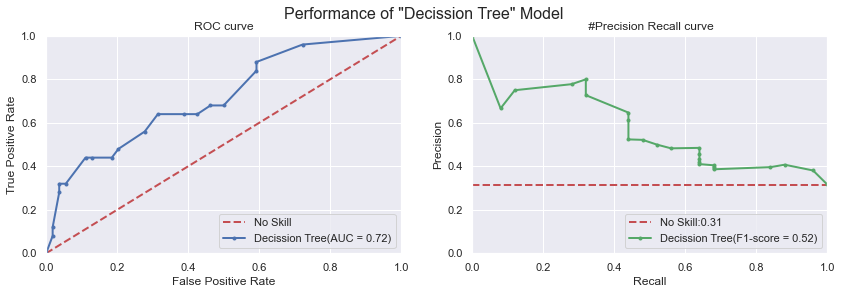

In [148]:
y_test_pred_prob_best_dt=best_dt_model.predict_proba(x_test)
plot_roc_auc_pr_curves(y_test,y_test_pred_prob_best_dt[:,1],"Decission Tree",f1_score(y_test,y_test_pred_best_dt))

#### Lets try with Ensemble techniques
#### Random Forest Classifier

In [149]:
rf= RandomForestClassifier(random_state=30,n_jobs=-1,oob_score=True)
rf.fit(x_train,y_train)
rf.oob_score_

0.7171945701357466

In [150]:
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print("Testing Accuracy:", accuracy_score(y_train, y_train_pred_rf))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print(classification_report(y_train,y_train_pred_rf))

Testing Accuracy: 0.8642533936651584
Testing Accuracy: 0.6962025316455697
              precision    recall  f1-score   support

           0       0.86      0.95      0.91       304
           1       0.87      0.67      0.75       138

    accuracy                           0.86       442
   macro avg       0.87      0.81      0.83       442
weighted avg       0.86      0.86      0.86       442



In [151]:
print(classification_report(y_test,y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79        54
           1       0.53      0.40      0.45        25

    accuracy                           0.70        79
   macro avg       0.64      0.62      0.62        79
weighted avg       0.68      0.70      0.68        79



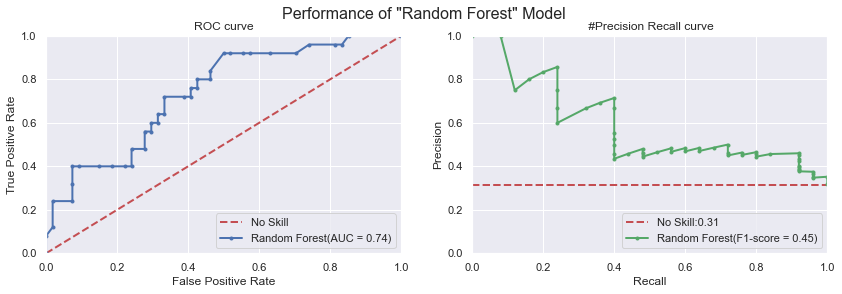

In [152]:
y_test_pred_prob_rf=rf.predict_proba(x_test)
plot_roc_auc_pr_curves(y_test,y_test_pred_prob_rf[:,1],"Random Forest",f1_score(y_test,y_test_pred_rf))

### Overfitting case

#### Random Forest Classifier with Hyper parameter tuning

In [153]:
parameters_rf ={
                'n_estimators' :[100,200,250,300],
                'criterion' : ['gini','entropy'],
                'max_depth' :[5,7,10],
                'min_samples_split' : [5,10],
                'min_samples_leaf' :[5,10],
                'max_features' : ['sqrt','log2'],
                'bootstrap' : [True],
                'oob_score' : [True],
                'n_jobs' : [-1]
    
               }

In [154]:
#instatiate the grid search model and fit the training data
grid_search=GridSearchCV(estimator=rf,param_grid=parameters_rf,cv=5,scoring='f1')
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=30),
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200, 250, 300], 'n_jobs': [-1],
                         'oob_score': [True]},
             scoring='f1')

In [155]:
best_rf_model_df=pd.DataFrame(grid_search.cv_results_)
best_rf_model_df.to_excel("2_RF_GRID.xlsx")

In [156]:
best_rf = RandomForestClassifier(random_state=30,bootstrap= True, 
criterion= 'entropy', 
max_depth= 5, 
max_features= 'sqrt',
min_samples_leaf= 5, 
min_samples_split= 10, 
n_estimators= 100, 
n_jobs= -1, 
oob_score= True)

In [157]:
best_rf.fit(x_train,y_train)
y_train_pred_best_rf = best_rf.predict(x_train)
y_test_pred_best_rf = best_rf.predict(x_test)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_best_rf))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred_best_rf))
print(classification_report(y_train,y_train_pred_best_rf))

Training Accuracy: 0.8076923076923077
Testing Accuracy: 0.7974683544303798
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       304
           1       0.90      0.43      0.59       138

    accuracy                           0.81       442
   macro avg       0.84      0.71      0.73       442
weighted avg       0.82      0.81      0.78       442



In [158]:
print(classification_report(y_test,y_test_pred_best_rf))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87        54
           1       0.91      0.40      0.56        25

    accuracy                           0.80        79
   macro avg       0.84      0.69      0.71        79
weighted avg       0.82      0.80      0.77        79



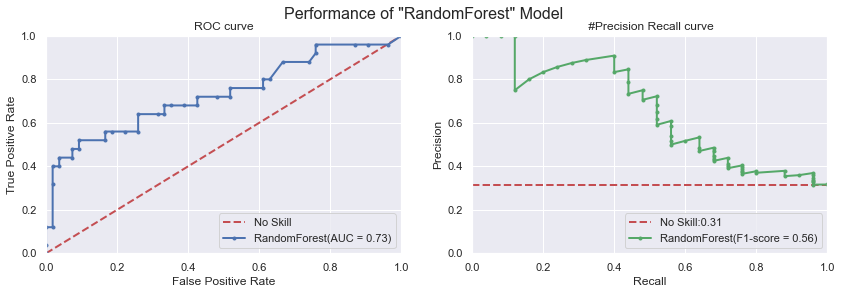

In [159]:
y_test_pred_prob_best_rf=best_rf.predict_proba(x_test)
plot_roc_auc_pr_curves(y_test,y_test_pred_prob_best_rf[:,1],'RandomForest',f1_score(y_test,y_test_pred_best_rf))

### Adaboost

In [160]:
adaboost_clf = AdaBoostClassifier(n_estimators=100,random_state=40,base_estimator = DecisionTreeClassifier(random_state=40))

In [161]:
adaboost_clf.fit(x_train,y_train)
y_train_pred_adb = adaboost_clf.predict(x_train)
y_test_pred_adb = adaboost_clf.predict(x_test)

In [162]:
print("Training Accuracy:",(accuracy_score(y_train,y_train_pred_adb)))
print("Testing Accuracy:",(accuracy_score(y_test,y_test_pred_adb)))
print(classification_report(y_train,y_train_pred_adb))

Training Accuracy: 0.8665158371040724
Testing Accuracy: 0.7088607594936709
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       304
           1       0.86      0.69      0.76       138

    accuracy                           0.87       442
   macro avg       0.86      0.82      0.84       442
weighted avg       0.87      0.87      0.86       442



In [163]:
print(classification_report(y_test,y_test_pred_adb))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80        54
           1       0.56      0.40      0.47        25

    accuracy                           0.71        79
   macro avg       0.65      0.63      0.63        79
weighted avg       0.69      0.71      0.69        79



In [164]:
### lets try to tune the Hyperparameters with Adaboost

In [165]:
parameters = { 
    
    'n_estimators':[100,150,200,250,300],
    'learning_rate':[0.01,0.1,1]
    
}

In [166]:
grid_search_ada = GridSearchCV(estimator = adaboost_clf, param_grid=parameters, scoring = 'f1', n_jobs = -1, cv=5 , return_train_score=True,verbose=5)
grid_search_ada.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=40),
                                          n_estimators=100, random_state=40),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [100, 150, 200, 250, 300]},
             return_train_score=True, scoring='f1', verbose=5)

In [167]:
ad_boost_best_model_df=pd.DataFrame(grid_search_ada.cv_results_)
ad_boost_best_model_df.to_excel("3_Adaboost_GRID.xlsx")

In [168]:
ad_boost_best_model =  AdaBoostClassifier(n_estimators=100, learning_rate=1,random_state=40)

In [169]:
ad_boost_best_model.fit(x_train,y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=40)

In [170]:
y_train_pred_best_ad = ad_boost_best_model.predict(x_train)
y_test_pred_best_ad = ad_boost_best_model.predict(x_test)

In [171]:
print("Training Accuracy:",(accuracy_score(y_train,y_train_pred_best_ad)))
print("Testing Accuracy:",(accuracy_score(y_test,y_test_pred_best_ad)))
print(classification_report(y_train,y_train_pred_best_ad))

Training Accuracy: 0.7895927601809954
Testing Accuracy: 0.7721518987341772
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       304
           1       0.76      0.47      0.58       138

    accuracy                           0.79       442
   macro avg       0.78      0.70      0.72       442
weighted avg       0.79      0.79      0.77       442



In [172]:
print(classification_report(y_test,y_test_pred_best_ad))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        54
           1       0.73      0.44      0.55        25

    accuracy                           0.77        79
   macro avg       0.76      0.68      0.70        79
weighted avg       0.77      0.77      0.75        79



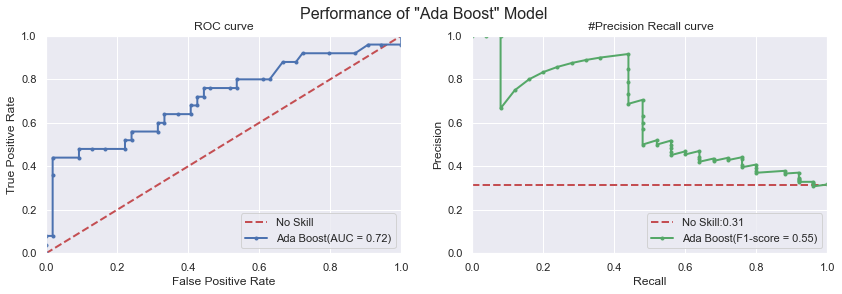

In [173]:
y_test_pred_prob_ada_boost= ad_boost_best_model.predict_proba(x_test)
plot_roc_auc_pr_curves(y_test,y_test_pred_prob_ada_boost[:,1],"Ada Boost",f1_score(y_test,y_test_pred_best_ad))

### Gradient boosting

In [174]:
gbc = GradientBoostingClassifier(random_state=42)
parameters = {
    "n_estimators":[150,250,300,350],
    "max_depth":[3,5,7,9],
    "learning_rate":[0.01,0.1,1],
    'min_samples_split':[5,10,15],
    'min_samples_leaf':[5,10,15]
}

In [175]:
grid_search_gb = GridSearchCV(estimator = gbc, param_grid=parameters, scoring = ['f1','accuracy','roc_auc'],refit='f1', n_jobs = -1, cv=5 , return_train_score=True,verbose=5)
grid_search_gb.fit(x_train,y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [150, 250, 300, 350]},
             refit='f1', return_train_score=True,
             scoring=['f1', 'accuracy', 'roc_auc'], verbose=5)

In [176]:
gb_boost_model_df=pd.DataFrame(grid_search_gb.cv_results_)
gb_boost_model_df.to_excel("4_Gradboost_GRID.xlsx")

In [177]:
gb_boost_best_model =  GradientBoostingClassifier(learning_rate= 0.01, max_depth= 3, min_samples_leaf= 5, min_samples_split= 15, n_estimators= 300,random_state=42)

In [178]:
gb_boost_best_model.fit(x_train,y_train)

GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=5,
                           min_samples_split=15, n_estimators=300,
                           random_state=42)

In [179]:
y_train_pred_best_gb = gb_boost_best_model.predict(x_train)
y_test_pred_best_gb = gb_boost_best_model.predict(x_test)

In [180]:
print("Training Accuracy:",(accuracy_score(y_train,y_train_pred_best_gb)))
print("Testing Accuracy:",(accuracy_score(y_test,y_test_pred_best_gb)))
print(classification_report(y_train,y_train_pred_best_gb))

Training Accuracy: 0.8099547511312217
Testing Accuracy: 0.7974683544303798
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       304
           1       0.89      0.45      0.60       138

    accuracy                           0.81       442
   macro avg       0.84      0.71      0.74       442
weighted avg       0.82      0.81      0.79       442



In [181]:
print(classification_report(y_test,y_test_pred_best_gb))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87        54
           1       0.91      0.40      0.56        25

    accuracy                           0.80        79
   macro avg       0.84      0.69      0.71        79
weighted avg       0.82      0.80      0.77        79



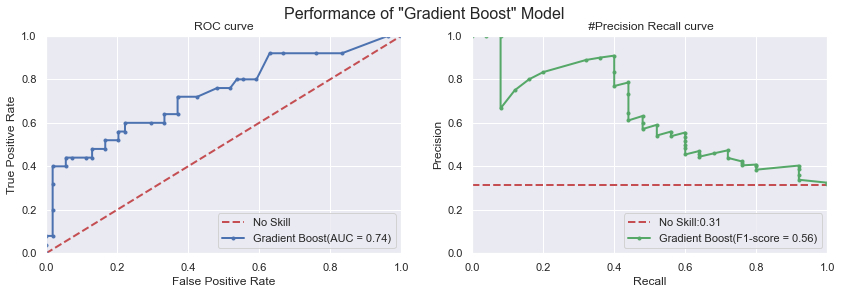

In [182]:
y_test_pred_prob_gbc_boost= gb_boost_best_model.predict_proba(x_test)
plot_roc_auc_pr_curves(y_test,y_test_pred_prob_gbc_boost[:,1],"Gradient Boost",f1_score(y_test,y_test_pred_best_gb))

In [183]:
model_summary_list=[]
model_summary_dict={}

In [184]:
dict_classifiers = {
    "Logistic_Regression": log_reg,
    "Decission_Tree":best_dt_model,
    "Random_Forest": best_rf,
    "AdaBoost": ad_boost_best_model,
    "GradientBoost": gb_boost_best_model
}

In [185]:
for model, model_instantiation in dict_classifiers.items():
    model_summary_dict={}
    model_summary_dict["Model"]= model
    model_summary_dict["Train_Accuracy"]=accuracy_score(y_train,model_instantiation.predict(x_train))
    model_summary_dict["Test_Accuracy"]=accuracy_score(y_test,model_instantiation.predict(x_test))
    model_summary_dict["Precision"]=precision_score(y_test,model_instantiation.predict(x_test))
    model_summary_dict["Recall"]=recall_score(y_test,model_instantiation.predict(x_test))
    model_summary_dict["F1_Score"]=f1_score(y_test,model_instantiation.predict(x_test))
    model_summary_dict["Roc_AUC"]=roc_auc_score(y_test,model_instantiation.predict_proba(x_test)[:,1])
    model_summary_list.append(model_summary_dict)

In [186]:
model_summary_df = pd.DataFrame(model_summary_list)
model_summary_df

,Model,Train_Accuracy,Test_Accuracy,Precision,Recall,F1_Score,Roc_AUC
0,Logistic_Regression,0.798643,0.759494,0.714286,0.40,0.512821,0.752222
1,Decission_Tree,0.798643,0.746835,0.647059,0.44,0.523810,0.715926
2,Random_Forest,0.807692,0.797468,0.909091,0.40,0.555556,0.732222
3,AdaBoost,0.789593,0.772152,0.733333,0.44,0.550000,0.716667
4,GradientBoost,0.809955,0.797468,0.909091,0.40,0.555556,0.735556


##### From the summary we can choose the top 3 models 
1. Gradient Boost has similar performance as Random forest
2. Adaboost
3. Logistic Regression

In [187]:
## Import Test data

In [188]:
test_df=pd.read_excel("Consumer creditworthiness test data.xlsx")

In [189]:
missing_cols_list,missing_col_df=find_missing_values(test_df)
missing_col_df

,0,1,2,3
0,Gender,Dependents,Self_Employed,Credit_History
1,3.226%,2.151%,5.376%,7.527%


In [190]:
treat_missing_values(test_df,missing_cols_list)
missing_cols_list_after,missing_col_df_after=find_missing_values(test_df)
missing_col_df_after

""


In [191]:
summary_df=custom_summary_func1(test_df)
summary_df

,Feature_Name,Count,lower_whisker,min,Q1,Q2,Q3,upper_whisker,max,mean,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
0,Loan_ID,93,-323543.5,100859.0,318140.0,487107.0,745929.0,1387612.5,996592.0,5.324596e+05,7.160867e+10,2.675980e+05,0.161254,-1.107287,Fairly positively skewed,Platykurtic,No Outliers
1,ApplicantIncome,93,-367762.5,93600.0,652500.0,827100.0,1332675.0,2352937.5,4383900.0,1.139431e+06,7.021584e+11,8.379489e+05,2.237350,5.196276,Highly positively skewed,Leptokurtic,Has Outliers
2,CoapplicantIncome,93,-753300.0,0.0,0.0,120600.0,502200.0,1255500.0,9375075.0,4.498258e+05,1.564324e+12,1.250729e+06,6.114822,39.491122,Highly positively skewed,Leptokurtic,Has Outliers
3,LoanAmount,93,-43000.0,0.0,200000.0,260000.0,362000.0,605000.0,1200000.0,2.997419e+05,4.103498e+10,2.025709e+05,1.925319,5.555195,Highly positively skewed,Leptokurtic,Has Outliers
4,Loan_Amount_Term,93,360.0,36.0,360.0,360.0,360.0,360.0,480.0,3.350968e+02,5.300570e+03,7.280499e+01,-2.442393,5.627670,Highly negatively skewed,Leptokurtic,Has Outliers
5,Credit_History,93,1.0,0.0,1.0,1.0,1.0,1.0,1.0,8.279570e-01,1.400000e-01,3.794635e-01,-1.766520,1.144748,Highly negatively skewed,Leptokurtic,Has Outliers


In [192]:
test_df['Total_Income']=test_df['ApplicantIncome']+test_df['CoapplicantIncome']

In [193]:
summary_df=custom_summary_func1(test_df)
summary_df

,Feature_Name,Count,lower_whisker,min,Q1,Q2,Q3,upper_whisker,max,mean,variance,std_dev,skewness,kurtosis,skewness_comment,kurtosis_comment,outlier_comment
0,Loan_ID,93,-323543.5,100859.0,318140.0,487107.0,745929.0,1387612.5,996592.0,5.324596e+05,7.160867e+10,2.675980e+05,0.161254,-1.107287,Fairly positively skewed,Platykurtic,No Outliers
1,ApplicantIncome,93,-367762.5,93600.0,652500.0,827100.0,1332675.0,2352937.5,4383900.0,1.139431e+06,7.021584e+11,8.379489e+05,2.237350,5.196276,Highly positively skewed,Leptokurtic,Has Outliers
2,CoapplicantIncome,93,-753300.0,0.0,0.0,120600.0,502200.0,1255500.0,9375075.0,4.498258e+05,1.564324e+12,1.250729e+06,6.114822,39.491122,Highly positively skewed,Leptokurtic,Has Outliers
3,LoanAmount,93,-43000.0,0.0,200000.0,260000.0,362000.0,605000.0,1200000.0,2.997419e+05,4.103498e+10,2.025709e+05,1.925319,5.555195,Highly positively skewed,Leptokurtic,Has Outliers
4,Loan_Amount_Term,93,360.0,36.0,360.0,360.0,360.0,360.0,480.0,3.350968e+02,5.300570e+03,7.280499e+01,-2.442393,5.627670,Highly negatively skewed,Leptokurtic,Has Outliers
5,Credit_History,93,1.0,0.0,1.0,1.0,1.0,1.0,1.0,8.279570e-01,1.400000e-01,3.794635e-01,-1.766520,1.144748,Highly negatively skewed,Leptokurtic,Has Outliers
6,Total_Income,93,-148387.5,423000.0,923850.0,1305000.0,1638675.0,2710912.5,9468675.0,1.589257e+06,1.773920e+12,1.331886e+06,3.832022,18.178611,Highly positively skewed,Leptokurtic,Has Outliers


In [194]:
income_label_2 = ['Low','Average','High','Very_High']
income_bins_2  = [320000.0, 938000.0, 1700000.0, 2900000.0,20000000.0]
test_df['Total_Income_category'] = pd.cut(test_df['Total_Income'],bins=income_bins_2,labels=income_label_2)
test_df['Total_Income_category'] = test_df.Total_Income_category.astype('object')

In [195]:
test_df['Total_Income_category'].value_counts()

Average      48
Low          24
High         13
Very_High     8
Name: Total_Income_category, dtype: int64

In [196]:
loan_amount_labels=['Low','Average','High','Very_High']
loan_amount_bins=[0.0, 200000.0, 320000.0,506000.0,1500000.0]
test_df['Loan_Amount_category'] = pd.cut(test_df['LoanAmount'],bins=loan_amount_bins,labels=loan_amount_labels,include_lowest=True)
test_df['Loan_Amount_category'] = test_df.Loan_Amount_category.astype('object')

In [197]:
test_df['Loan_Amount_category'].value_counts()

Average      36
Low          25
High         21
Very_High    11
Name: Loan_Amount_category, dtype: int64

In [198]:
test_df["Applicant_Capital"] = ((test_df["Property_Area"].isin(["Urban","Semiurban"])) & (test_df["Credit_History"]==1))
test_df["Applicant_Capital"] = test_df["Applicant_Capital"].map({True:1,False:0})

In [199]:
test_df["Gender_M_with_Credithistory"] = ((test_df["Gender"].isin(["Male"])) & (test_df["Credit_History"]==1))
test_df["Gender_M_with_Credithistory"] = test_df["Gender_M_with_Credithistory"].map({True:1,False:0})

In [200]:
test_df["Gender_M_Married"] = ((test_df["Gender"].isin(["Male"])) & (test_df["Married"]=='Yes'))
test_df["Gender_M_Married"] = test_df["Gender_M_Married"].map({True:1,False:0})

In [201]:
test_df["Selfemployed_with_Credithistory"] = ((test_df["Self_Employed"].isin(["No"])) & (test_df["Credit_History"]==1))
test_df["Selfemployed_with_Credithistory"] = test_df["Selfemployed_with_Credithistory"].map({True:1,False:0})

In [202]:
test_df["Selfemployed_with_PropertyArea"] = ((test_df["Self_Employed"].isin(["No"])) & (test_df["Property_Area"].isin(["Urban","Semiurban"])))
test_df["Selfemployed_with_PropertyArea"] = test_df["Selfemployed_with_PropertyArea"].map({True:1,False:0})

In [203]:
test_df["Education"]=test_df["Education"].map(edu_dict)
test_df["Property_Area"]=test_df["Property_Area"].map(property_area)
test_df["Total_Income_category"] = test_df["Total_Income_category"].map(income_category)
test_df["Loan_Amount_category"] = test_df["Loan_Amount_category"].map(income_category)

In [204]:
x_test_final=test_df[['Education',
'Property_Area',
'Total_Income_category',
'Loan_Amount_category',
'Applicant_Capital',
'Gender_M_with_Credithistory',
'Gender_M_Married',
'Selfemployed_with_Credithistory',
'Selfemployed_with_PropertyArea']]

In [205]:
x_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Education                        93 non-null     int64
 1   Property_Area                    93 non-null     int64
 2   Total_Income_category            93 non-null     int64
 3   Loan_Amount_category             93 non-null     int64
 4   Applicant_Capital                93 non-null     int64
 5   Gender_M_with_Credithistory      93 non-null     int64
 6   Gender_M_Married                 93 non-null     int64
 7   Selfemployed_with_Credithistory  93 non-null     int64
 8   Selfemployed_with_PropertyArea   93 non-null     int64
dtypes: int64(9)
memory usage: 6.7 KB


In [206]:
dict_classifiers_top3 = {
                            "GradientBoost": gb_boost_best_model,
                            "Logistic_Regression": log_reg,
                            "AdaBoost": ad_boost_best_model,
                        }

In [207]:
y_test_final_pred_gb = gb_boost_best_model.predict(x_test_final)
y_test_final_pred_ab = ad_boost_best_model.predict(x_test_final)
y_test_final_pred_logreg = log_reg.predict(x_test_final)

In [208]:
test_df["Grad_boost_pred"] = y_test_final_pred_gb
test_df["Ada_boost_pred"] = y_test_final_pred_ab
test_df["Logreg_boost_pred"] = y_test_final_pred_logreg

In [209]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Loan_ID                          93 non-null     int64  
 1   Gender                           93 non-null     object 
 2   Married                          93 non-null     object 
 3   Dependents                       93 non-null     object 
 4   Education                        93 non-null     int64  
 5   Self_Employed                    93 non-null     object 
 6   ApplicantIncome                  93 non-null     int64  
 7   CoapplicantIncome                93 non-null     int64  
 8   LoanAmount                       93 non-null     int64  
 9   Loan_Amount_Term                 93 non-null     int64  
 10  Credit_History                   93 non-null     float64
 11  Property_Area                    93 non-null     int64  
 12  Total_Income            

In [210]:
test_df.to_excel("consumer creditworthiness test data output.xlsx")